<a href="https://colab.research.google.com/github/kifayat-en/Sentiment-Analysis-on-IMDB-Reviews-with-LSTM/blob/main/Imdb_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import pandas as pd
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [57]:
file_name = '/content/drive/MyDrive/IMDB Dataset.csv.zip'
with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('DONE')

DONE


In [58]:
df = pd.read_csv('/content/IMDB Dataset.csv')

In [59]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [60]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [61]:
df.replace({'sentiment': {'positive':1, 'negative':0}}, inplace=True)

<ipython-input-61-4e61e05039dc>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'sentiment': {'positive':1, 'negative':0}}, inplace=True)


In [62]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [63]:
train_data, test_data = train_test_split(df,test_size=0.2, random_state=42)
print(train_data.shape)
print(test_data.shape)


(40000, 2)
(10000, 2)


Data preprocessing

In [64]:
df['review'] = df['review'].str.lower() #convert lower case

def remove_html_tags(txt): # All html tags removes
  pattern = re.compile('<.*?>')
  return pattern.sub('r', txt)

df['review'] = df['review'].apply(remove_html_tags)



In [65]:
import string
punct = string.punctuation
def remove_punctuation(text): # remves all punctuations in data
  return text.translate(str.maketrans('', '', punct))

In [66]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['review'])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['review']), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['review']), maxlen=200)


In [67]:
print(X_train)

[[1935    1 1200 ...  205  351 3856]
 [   3 1651  595 ...   89  103    9]
 [   0    0    0 ...    2  710   62]
 ...
 [   0    0    0 ... 1641    2  603]
 [   0    0    0 ...  245  103  125]
 [   0    0    0 ...   70   73 2062]]


In [68]:
print(X_test)

[[   0    0    0 ...  995  719  155]
 [  12  162   59 ...  380    7    7]
 [   0    0    0 ...   50 1088   96]
 ...
 [   0    0    0 ...  125  200 3241]
 [   0    0    0 ... 1066    1 2305]
 [   0    0    0 ...    1  332   27]]


In [69]:
y_train = train_data['sentiment']
y_test = test_data['sentiment']



In [70]:
y_train

,sentiment
39087,0
30893,0
45278,1
16398,0
13653,0
...,...
11284,1
44732,1
38158,0
860,1


LSTM

In [73]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [76]:
model.build(input_shape=(None, 100))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 772,225 (2.95 MB)

 Trainable params: 771,969 (2.94 MB)

 Non-trainable params: 256 (1.00 KB)

In [77]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [78]:
hist = model.fit(X_train, y_train, epochs=5, validation_split=0.2, batch_size=64)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 224s 433ms/step - accuracy: 0.7229 - loss: 0.5316 - val_accuracy: 0.8618 - val_loss: 0.3272
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 242s 401ms/step - accuracy: 0.8572 - loss: 0.3383 - val_accuracy: 0.8393 - val_loss: 0.3583
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 201s 399ms/step - accuracy: 0.8626 - loss: 0.3252 - val_accuracy: 0.8536 - val_loss: 0.3500
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 201s 397ms/step - accuracy: 0.8959 - loss: 0.2526 - val_accuracy: 0.8475 - val_loss: 0.3916
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 202s 398ms/step - accuracy: 0.9232 - loss: 0.1951 - val_accuracy: 0.8748 - val_loss: 0.3051


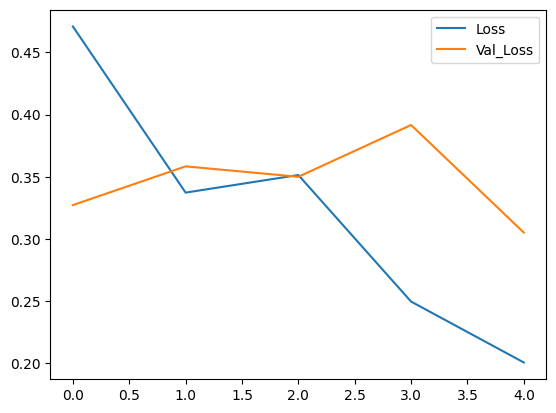

In [82]:
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Val_Loss')
plt.legend()
plt.show()

In [79]:
test_loss, test_accuracy  = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')



313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.8812 - loss: 0.2916
Test Loss: 0.28609004616737366
Test Accuracy: 0.883400022983551


In [85]:
y_pred = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step


In [87]:
model.save('Imdb_model.h5')